In [1]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import importlib

sys.path.append('C:\\Users\\kpandit\\PICASSO\\picasso\\')
import mine
importlib.reload(mine)
torch.cuda.is_available()

False

In [9]:
from pyseq import image_analysis as ia
import imageio

image_path = 'Y:\\Kunal\\HiSeqExperiments\\20210323_4i4color\\zarrs'
im = ia.get_HiSeqImages(image_path)
im.im
opt_obj_step = im.im.obj_step[1]
roi_center = (5594, 3548) # row, col
roi_size = 256
rows = slice(int(roi_center[0]-roi_size/2), int(roi_center[0]+roi_size/2))
cols = slice(int(roi_center[1]-roi_size/2), int(roi_center[1]+roi_size/2))
#im.show(selection = {'row':rows, 'col':cols, 'obj_step':25228})
test_image = im.im.sel(row = rows, col = cols, obj_step = opt_obj_step, cycle = 5)
test_images = []
for ch in test_image.channel:
        test_images.append(test_image.sel(channel=ch).values)

#imageio.mimwrite('mouse_spinalcord_small.tiff', test_images)

ImageAnalysis::Opened m4 


In [68]:
from typing import Union
import dask.array as da
import xarray as xr

class PICASSOnn(nn.Module):
    def __init__(self, mixing_matrix, 
                 transform: Union[None, nn.Module] = None, 
                 background: bool = True, 
                 px_bit_depth: int = 12, 
                 mi_weight: float  = 1.0, 
                 contrast_weight: float = 1.0):

        super().__init__()
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        self.mixing_matrix = torch.tensor(mixing_matrix, device = self.device)
        # Pairs property take mixing matrix as input to set
        self.pairs = self.mixing_matrix 
        
        self.bit_depth = px_bit_depth
        self.max_px = 2**px_bit_depth-1

        self.clip = nn.Hardtanh(min_val=0.0, max_val=1.0)
        if transform is None:
            self.transform = MixModel(self.n_images, self.n_sinks, self.mixing_matrix, background)
        else:
            self.transform = transform
        self.transform.to(self.device)
        
        
        self.mine_ = []
        self.mine_params = []
        for i in range(self.n_pairs):
            self.mine_.append(mine.MINE())
            for param in self.mine_[-1].parameters():
                self.mine_params.append(param)
        self.mi_loss = torch.zeros((self.n_pairs,), requires_grad = False, device = self.device)
        self.mi_weight = mi_weight
        
        self.contrast_weight = contrast_weight
        
        self.grad_thresh = None

        
        
    def contrast_loss(self, x, y, k2 = 0.03):
        
        c2 = (1*k2)**2
        varx = torch.var(x, dim = 0)
        vary = torch.var(y, dim = 0)
        score = (2*varx**0.5*vary**0.5+c2)/(varx+vary+c2)
        
        score = 1-score #keep contrast similiar
        
        return score

    
    def forward(self, images):
        ''' images NxC: N = number of px, C = number of channels'''
        
        #images = images/self.max_px

        # Remove spillover spectras in sink images
        no_spill = self.transform(images)
              
        # Keep contrast of sink image the same
        self.c_loss = self.contrast_loss(images[:,self.sink_ind], no_spill)*self.contrast_weight
        c_loss = torch.sum(self.c_loss)
        
        # Minimize mutual information between cleaned sink image and source images
        mi_loss = torch.tensor(0)
        for i, (snk, src) in enumerate(self.pairs):
            xy = torch.stack([no_spill[:,snk], images[:,src]], 1)
            mi = (1-self.mine_[i].forward(xy))*self.mi_weight 
            
            scale = 1
            if 0 <= mi < 1:
                scale = mi
            elif mi < 0:
                scale = 0
            mi = mi * scale
#             mi = self.mine_[i].forward(xy)*self.mi_weight

            self.mi_loss[i] = mi
            mi_loss = mi_loss + mi
#         max_mi = torch.max(self.mi_loss).detach()
#         for mi in self.mi_loss:
#             if mi < 0:
#                 mi = mi * c_loss
#             mi_loss = mi_loss + mi
            
        total_loss = mi_loss + c_loss
        
        return total_loss, self.mi_loss, self.c_loss

    
            
    def train_loop(self, images, max_iter=40, batch_size=500, lr=1e-4, opt=None):
       
        self.grad_thresh = None
        
        mix_params = [self.transform.alpha]
        bg_params = [self.transform.background]
                
#         mine_params = []    
#         for module in self.mine_:
#             mine_params.append(module.parameters())

    
        if opt is None:
            opt = torch.optim.Adam([{'params':self.mine_params, 'lr':lr}, 
                                    {'params':mix_params, 'lr': lr/10},
                                    {'params':bg_params, 'lr': lr/10}
                                   ])
         
        mix_params_ = []
        mi_loss_ = []
        contrast_loss_ = []
        old_param = 0
        
        dataset = self.get_dataset(images, batch_size = batch_size)
        
        for i in range(1, max_iter + 1):

            batch_loss = 0; batch_mi_loss = 0; batch_contrast_loss = 0
            for batch, im_list in enumerate(DataLoader(dataset, shuffle=True, collate_fn = dask_collate, pin_memory=True)):
                
                if len(im_list) == 1:
                    im = im_list[0]
                else:
                    im = torch.stack(im_list, dim=0)
                    
                opt.zero_grad()
                total_loss, mi_loss, contrast_loss  = self.forward(im)
                total_loss.backward()
                ap = self.transform.get_parameters()
#                 if self.grad_thresh is None:
#                     self.grad_thresh = nn.utils.clip_grad_norm_(self.mine_params, 100)*2
#                 else:
#                     mi_g_norm = nn.utils.clip_grad_norm_(self.mine_params, max_norm = self.grad_thresh)

                opt.step()
                self.transform.constrain()
                
                batch_loss += total_loss.item()
                batch_mi_loss += torch.sum(mi_loss).item()
                batch_contrast_loss += torch.sum(contrast_loss).item()

                # Save mixing parameters over iterations
                mix_params_.append(ap)
                    
                # Save losses over iterations
                mi_loss_.append(mi_loss.detach().tolist())
                contrast_loss_.append(contrast_loss.detach().tolist())


            loss_ = np.array([batch_loss, batch_mi_loss, batch_contrast_loss])
            loss_ /= batch
            if i % (max_iter // 10) == 0:
                print(ap)
#                 print(mi_g_norm)
                #print(f'It {i} - total norm: {tn}, alpha norm: {an}')
                print(f"It {i} - total loss: {loss_[0]}, total MI loss: {loss_[1]}, total contrast loss: {loss_[2]}")
                
            # TODO: Convergence of mixing parameters
#             new_param = self.flatten_parameters()
#             param_norm = torch.linalg.norm(new_param - old_param)
#             old_param = new_param                
#             if param_norm.item() < 0.05:
#                 print(f"Converged in {i} iterations")
#                 break


        train_info = {'mixing parameters': mix_params_,
                      'mutual information loss': mi_loss_,
                      'contrast loss': contrast_loss_}
            
        return train_info
    
    def get_dataset(self, images, batch_size=-1):
        
        da_type = type(da.zeros(0))
        np_type = type(np.zeros(0))
        xr_type = type(xr.DataArray([0]))
        im_type = type(images)
        
        im_stack = []
        if im_type in [list, tuple]:
        # Handle iterable of images
            assert images[0].ndim == 2, f'Expected iterable of 2D images'
            n_im = len(images)
            rows, cols = images[0].shape
            
            for i in images:
                im_type_ = type(i)
                if im_type_ is np_type:
                    im_stack.append(da.from_array(i).flatten())
                elif im_type_ is da_type:
                    im_stack.append(i.flatten())
                
        elif im_type in [da_type, np_type, xr_type]:
        #Handle 3D array of images
            #TODO handle n dim
            assert images.ndim == 3, f'3D stack of images, with dim 0 as the stack dimension'
            n_im, row, cols = images.shape
            if im_type is xr_type:
                images = images.data
                im_type = type(images)
            
            for i in range(n_im):
                if im_type is np_type:
                    im_stack.append(da.from_array(images[i,:,:]).flatten())
                elif im_type is da_type:
                    im_stack.append(images[i,:,:].flatten())
        else:
            raise TypeError('Did not recognize images')
                
                
        dataset = da.stack(im_stack, axis=1)
                
        
#         assert len(images) == self.n_images, f'Expecting {self.n_images} images, got {shape[0]} images'
        
#         ims = []
#         for i in images:
#             i i.ndim == 2, f'Expecting 2D image'
#             if isinstance(i, type(np.zeros(0))):
#                 ims.append(torch.tensor(i.flatten(), dtype = torch.float32))
#             elif isinstance(i, type(da.zeros(0))):
#                 ims.append(torch.tensor(i.flatten().compute(), dtype = torch.float32))
#             # TODO what type are napari arrays?
#             else:
#                 raise f'Expecting numpy or dask array'
                
                
        return PICASSO_Dataset(dataset, px_per_chunk=batch_size)
        
        
    
    def unmix_images(self, images, batch_size: int = 1):
        
        n_ims = len(images)
        h, w = images[0].shape
        dataset = self.get_dataset(images)
        
        batches = []
        for batch, im in enumerate(DataLoader(dataset, batch_size)):
            unmixed_batch = self.transform(im)
            batches.append(unmixed_batch.detach().cpu())
        unmixed_ims = np.vstack(batches)
        unmixed_ims_ = []
        px, n_ims = unmixed_ims.shape
        for i in range(n_ims):
            unmixed_ims_.append(unmixed_ims[:,i].reshape(h,w))
        
        return unmixed_ims_
              
        
    @property
    def pairs(self):
        return self._pairs
    
    @pairs.setter
    def pairs(self, mixing_matrix):
        '''Set list of pairs (sink index, source index).'''
    
        images, sinks = self._mixing_matrix.shape
        
        self._pairs = []
        for i in range(images):
            for ii in range(sinks):
                if self.mixing_matrix[i,ii] == -1:
                    self._pairs.append((ii, i))
                    
        self.n_pairs = len(self._pairs)
    
    @property
    def mixing_matrix(self):
        return self._mixing_matrix
    
    @mixing_matrix.setter
    def mixing_matrix(self, mm):
        '''Check and set the mixing matrix.
        
           rows = all images
           cols = unmixed images
           
           Mark a sink image with a 1, only 1 sink image per column.
           Mark a source image with a -1
           All other images should be 0.
           
        '''
        
        n_src, n_snk = mm.shape
        assert n_snk >= n_src, f'Number of sinks {n_snk} must be >= number of sources {n_src}'
        if n_src == n_snk:
            assert (mm.diagonal() == 1).all(), f'Diagonal of mixing matrix should be 1s'
            off_diag = mm[~torch.eye(mm.shape[0],dtype=bool)] 
            assert ((off_diag==0) | (off_diag==-1)).all(), f'Off diagonal of mixing matrix should be -1s or 0s'
        else:
            assert ((mm==0) | (mm==-1) | (mm==1)).all(), f'Mixing matrix should only include -1s, 0s, or 1s'
        
        assert (mm==1).sum(axis=1).all() <= 1, f'Only 1 image can be marked as a sink per column in the mixing matrix'
            
        # Remove unused sources
        mm = mm[~((mm==0).sum(dim=0) == n_snk)]
        # Remove unused sinks
        mm = mm[~((mm==0).sum(dim=1) == n_src)]
        
        self.source_ind = ~(mm.sum(dim=1) == 1)
        self.sink_ind = (mm==-1).sum(dim=0) >= 1
        
        # Get images x sink mixing matrix (columns have 1 sink and at least one source image)
        self._mixing_matrix = mm[:, self.sink_ind]
        self.n_images, self.n_sinks = self._mixing_matrix.shape
    
        
                
class MixModel(nn.Module):
    def __init__(self, images:int, sinks:int, mixing_matrix, background: bool = True, 
                 min_alpha:float = 0.01, max_alpha:float = 2.0, max_background:float = 0.1):
        
        super().__init__()
        
        assert (images, sinks) == mixing_matrix.shape, f'Mixing matrix rows should = images, and cols should = sinks'
        
        self.mixing_matrix = mixing_matrix
        self.bg = background
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha
        self.max_background = max_background
        self.images = images
        self.sinks = sinks
        
        self.Hardtanh = nn.Hardtanh(min_val=0.0, max_val=1.0)
        
        self.alpha = nn.Parameter(torch.ones((images, sinks), dtype=torch.float32)/2)
        
        if background:
            self.background = nn.Parameter(torch.zeros((images, sinks), dtype=torch.float32))
            
        self.constrain()
        
    def forward(self, x):
        assert x.ndim == 2, f'Got {x.ndim}D matrix, expected 2D matrix of flattened images, rows = px, cols = images'
        px, images = x.shape
        
        assert images == self.images, f'Expected {self.images} images, got {images}'
        
        y = torch.zeros((px, self.sinks), dtype = torch.float32)
        if self.bg:
            for i in range(self.sinks):
                y[:,i] = self.Hardtanh(x-self.background[:,i].T) @ (self.alpha[:,i]*self.mixing_matrix[:,i])
        else:
            y = x @ (self.alpha*self.mixing_matrix)
            
        return self.Hardtanh(y)
        
    def constrain(self):
        
        alpha = self.alpha.data
        alpha = alpha.clamp(self.min_alpha, self.max_alpha)
        alpha[self.mixing_matrix == 1] = 1
        alpha[self.mixing_matrix == 0] = 0
        self.alpha.data = alpha
        
        if self.bg:
            background = self.background.data
            background = background.clamp(0.0, self.max_background)
            background[(self.mixing_matrix == 1) | (self.mixing_matrix == 0)] = 0.0
            self.background.data = background
        
    def get_parameters(self):

        params = []
        for i in range(self.images):
            for ii in range(self.sinks):
                if self.mixing_matrix[i,ii] == -1:
                    params.append([self.alpha[i,ii], self.background[i,ii]])
                    
        return torch.tensor(params)
    
        
print('ran')

ran


In [69]:
# Mixing matrix, rows are all images, cols are unmixed images
# Mark sink as 1 in unmixed image
# Mark sources as -1 unmixed image
# everythin else = 0


# small_mouse = pooch.retrieve(url="https://drive.google.com/file/d/1T8UEXdcG3wLPBj25npzeZUFXvynzqJDi/view?usp=sharing",
#                             known_hash=None, 
#                             )

mixing_matrix = [[1, -1, 0, 0],# sink 558, no spillover
                 [0, 1, 0, 0],# sink 610, spillover from 558
                 [0, 0, 1, -1],# sink 687, no spillover
                 [0, 0, 0, 1]]# sink 740, spillover from 687

picasso = PICASSOnn(mixing_matrix)
#dataset = picasso.get_dataset(test_images, batch_size=500)
#picasso.forward(ftorch.tensor(dataset, dtype=torch.float32))
train_info = picasso.train_loop(test_image, batch_size = 10000, max_iter=100, lr = 1e-3)

#picasso.c_loss

Using cpu
Using cpu
tensor([[0.4952, 0.0087],
        [0.4932, 0.0000]])
It 10 - total loss: 2.4084361791610718, total MI loss: 2.3303223649660745, total contrast loss: 0.07811381419499715
tensor([[4.8794e-01, 2.1891e-02],
        [4.8627e-01, 3.8387e-06]])
It 20 - total loss: 2.3813992738723755, total MI loss: 2.305582821369171, total contrast loss: 0.07581648230552673
tensor([[4.7599e-01, 3.8782e-02],
        [4.7939e-01, 4.5344e-04]])
It 30 - total loss: 2.196202298005422, total MI loss: 2.122685213883718, total contrast loss: 0.07351707418759663
tensor([[0.4642, 0.0511],
        [0.4725, 0.0046]])
It 40 - total loss: 1.7202003796895344, total MI loss: 1.6491131782531738, total contrast loss: 0.07108723123868306
tensor([[0.4555, 0.0580],
        [0.4651, 0.0217]])
It 50 - total loss: 1.3323543071746826, total MI loss: 1.263665239016215, total contrast loss: 0.06868907809257507
tensor([[0.4518, 0.0608],
        [0.4561, 0.0442]])
It 60 - total loss: 1.2207666238149006, total MI loss:

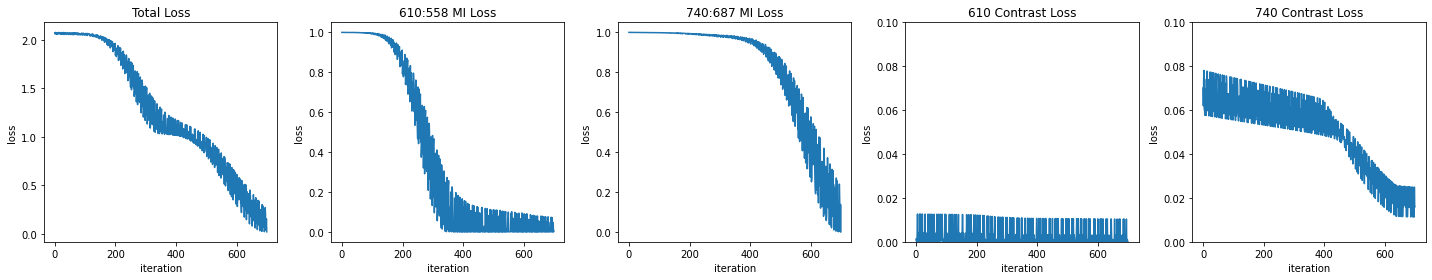

In [82]:
import matplotlib.pyplot as plt

c_loss  = np.array(train_info['contrast loss'])
mi_loss = np.array(train_info['mutual information loss'])
total_loss = c_loss.sum(axis=1) + mi_loss.sum(axis=1)

fig, axs = plt.subplots(1,5, figsize=(20,4))

def format_axs(ax, title=None, xlabel=None, ylabel=None):
    
    if title is not None:
        ax.set_title(str(title))
        
    if xlabel is not None:
        ax.set_xlabel(str(xlabel))
        
    if ylabel is not None:
        ax.set_ylabel(str(ylabel))
        
axs[0].plot(total_loss)
axs[1].plot(mi_loss[:,0])
axs[2].plot(mi_loss[:,1])
axs[3].plot(c_loss[:,0])
axs[4].plot(c_loss[:,1])

titles = ['Total Loss', '610:558 MI Loss', '740:687 MI Loss', '610 Contrast Loss', '740 Contrast Loss']

for i in range(5):
     format_axs(axs[i], title=titles[i], xlabel = 'iteration', ylabel = 'loss')
        
axs[3].set_ylim((0, 0.1))
axs[4].set_ylim((0, 0.1))
    
fig.tight_layout()
plt.savefig('loss.pdf', dpi=300)

<AxesSubplot:>

In [63]:
# picasso = PICASSOnn(mixing_matrix, background=True)
# alpha = picasso.transform.alpha.data
# alpha[0,0] = 0.65
# picasso.transform.alpha.data = alpha

# background = picasso.transform.background.data
# background[0,0] = 0.1
# picasso.transform.background.data = background

unmixed = picasso.unmix_images(test_images, batch_size = 500)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'dask.array.core.Array'>

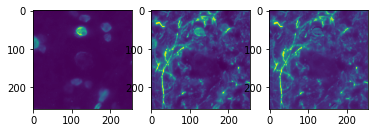

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3)


axs[0].imshow(test_images[0])
axs[1].imshow(test_images[1])
axs[2].imshow(unmixed[0])


plt.show()

In [79]:
test_images[0].shape

(256, 256)

In [12]:
alpha = np.arange(0,20)/10

mi_ = []
for a in alpha:
    X = test_image.sel(channel=558)
    Y = test_image.sel(channel=610) - a*X
    
    X = torch.tensor(X.values.flatten()/4095, dtype=torch.float32)
    Y = torch.tensor(Y.values.flatten()/4095, dtype=torch.float32)
    
    mi = mine.MINE()
    MI = mi.train_loop(X, Y)
    mi_.append(MI)

Using cpu
It 25 - MI: 0.022718265299882853
It 50 - MI: 0.05162276237299948
It 75 - MI: 0.061796960054021896
It 100 - MI: 0.07030222903598439
Using cpu
It 25 - MI: 0.012823196748892466
It 50 - MI: 0.03750464483869798
It 75 - MI: 0.05392670637053071
It 100 - MI: 0.06324444158059178
Using cpu
It 25 - MI: 0.018160183321345936
It 50 - MI: 0.036640435231454445
It 75 - MI: 0.041715219165339615
It 100 - MI: 0.04616368810335795
Using cpu
It 25 - MI: 0.0043473767511772385
It 50 - MI: 0.014195160883845705
It 75 - MI: 0.020972190707018883
It 100 - MI: 0.024338422399578674
Using cpu
It 25 - MI: 0.005224819661992969
It 50 - MI: 0.013137170424064001
It 75 - MI: 0.016886387810562595
It 100 - MI: 0.020267389488942696
Using cpu
It 25 - MI: 0.0032590343193574386
It 50 - MI: 0.009623330876682743
It 75 - MI: 0.01308760227579059
It 100 - MI: 0.01607200525926821
Using cpu
It 25 - MI: 7.892445181355332e-05
It 50 - MI: 0.00021385943347757512
It 75 - MI: 0.0004410296678543091
It 100 - MI: 0.0007184416507229661


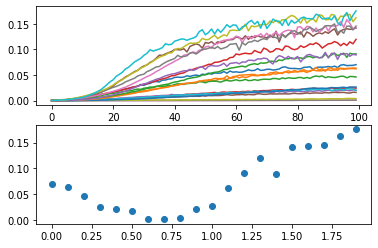

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1)
MI_ = []
for m in mi_:
    axs[0].plot(m)
    MI_.append(m[-1])
axs[1].scatter(alpha, MI_)

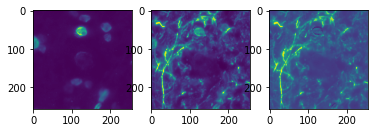

In [21]:
X = test_image.sel(channel=558)
Y = test_image.sel(channel=610)

fig, axs = plt.subplots(1,3)
axs[0].imshow(X)
axs[1].imshow(Y)
axs[2].imshow(Y-0.65*X)

In [35]:
import psutil
from math import ceil

mixing_matrix = [[1, -1, 0, 0],# sink 558, no spillover
                 [0, 1, 0, 0],# sink 610, spillover from 558
                 [0, 0, 1, -1],# sink 687, no spillover
                 [0, 0, 0, 1]]# sink 740, spillover from 687



class PICASSO_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, device = None, px_per_chunk=-1):
        
        super().__init__()
        
        # Get info about dataset
        self.max_px = dataset.max().compute()                          # max pixel value in images
        self.dataset = dataset.astype('float32')/self.max_px           # pixels normalized to 1
        self.blocks_per_image, self.n_images = dataset.blocks.shape    #chunk/blocks in each image, number of images 
        self.px_byte = np.dtype(dataset.dtype).itemsize                #bytes of each pixel
        #size of chunk in bytes
        self.chunk_byte = 1
        chunksize = dataset.chunksize       
        assert len(chunksize) == 2 and chunksize[1] == 1, f'Dataset should be flattened images arranged by column'
        for s in chunksize:
            self.chunk_byte *= s
        self.chunk_byte *= self.px_byte*self.n_images     
        self.chunk_px = chunksize[0]        #number of pixels in each chunk
            
        # Get info about system
        if device is None:
            if torch.cuda.is_available():
                self.device = 'cuda'
                self.gpu_prop = torch.cuda.get_device_properties('cuda')
                self.memory_size = self.gpu_mem.total_memory
            else:
                self.device = 'cpu'
                self.sys_prop = psutil.virtual_memory()
                self.memory_size = self.sys_prop.available
        f_mem = format_bytes(self.memory_size)
        
        # See if chunk will fit into memory
        self.fit_chunks = False
        self.mem_per_chunk = self.memory_size/(self.chunk_byte*self.n_images)
        self.px_in_mem = self.mem_per_chunk/2*self.chunk_px
        if self.mem_per_chunk > 0.5:
            self.fit_chunks = True
            
        # set pixels per chunk    
        if px_per_chunk > 0:
            assert px_per_chunk <= self.px_in_mem, f'Can only fit {self.px_in_mem} px in {f_mem} memory, not {px_per_chunk}'
            self.fit_chunks = False
            self.px_in_mem = px_per_chunk
        
        self.chunks = self.dataset
            
    def break_chunk(self, chunks):
        pim = self.px_in_mem
        n_breaks = ceil(self.chunk_px/pim)
        chunks_ = []
        for i in range(n_breaks):
            if i < n_breaks-1:
                chunks_.append(chunks[i*pim:(i+1)*pim,:])
            else:
                chunks_.append(chunks[i*pim:-1,:])
                
        return chunks_
    
    def __len__(self):
        return len(self.chunks)
        
    def __getitem__(self, index):
        return self.chunks[index]
                
    def __iter__(self):
        return iter(self.chunks)

    
    @property
    def chunks(self):
        return self._chunks
    
    @chunks.setter
    def chunks(self, dataset):
        
        cp = self.chunk_px
        samples = []
        indices = np.arange(self.blocks_per_image)
        
        for i in indices:
            chunks = dataset[i*cp:(i+1)*cp,:]
            if not self.fit_chunks:
                samples = samples + self.break_chunk(chunks)
            else:
                samples.append(chunks)
                
        self._chunks = samples
        

    
def dask_collate(chunks_, dtype = torch.float32, device = 'cpu'):
    
    da_type = type(da.zeros(0))
    _type = type(chunks_)
    
    assert _type in [da_type, list], f'Expected dask array or list, got {_type}'
    
    if _type is da_type:
        chunks = torch.tensor(chunks_.compute(), dtype=dtype, device = device)
    elif _type is list:
        chunks = [torch.tensor(c.compute(), dtype=dtype, device = device) for c in chunks_ ]
    
    return chunks
    
picasso = PICASSOnn(mixing_matrix, background=True)
dataset = picasso.get_dataset(test_image, batch_size = 500)
for im_list in DataLoader(dataset, shuffle=True, collate_fn = dask_collate, pin_memory=True):
    pass

Using cpu
Using cpu


NameError: name 'format_bytes' is not defined

In [169]:
for i in dataset:
    print(i)

dask.array<getitem, shape=(500, 4), dtype=float32, chunksize=(500, 1), chunktype=numpy.ndarray>


In [37]:
from dask.utils import format_bytes
#test_image.data.blocks.ravel()[0].compute()

In [90]:
test = im.im.sel(obj_step = opt_obj_step, cycle = 5)
test_stack = []
for i in range(4):
    test_stack.append(test[i,:,:].data.flatten())
test = da.stack(test_stack, axis=1)
byte_size = 1
for s in test.chunksize:
    byte_size *= s
print(byte_size)
format_bytes(byte_size*(16/8))
test.chunksize

18831360


(18831360, 1)

In [73]:
torch.cuda.get_device_properties()

TypeError: get_device_properties() missing 1 required positional argument: 'device'

In [81]:
import psutil
mem_test = psutil.virtual_memory()
format_bytes(mem_test.available)

'17.88 GiB'

In [82]:
format_bytes(mem_test.shared)

AttributeError: 'svmem' object has no attribute 'shared'

In [11]:
import pooch